#  Relatório - T2 - ÉPOCA ESPECIAL

**Gustavo Oliveira**, L46395 

**Engenharia Informática** - 2024/2025  

**Docente:** Teresa Gonçalves

---

**Data de Submissão:**  - 29/07/2025

---

**alterações realizadas:**  

Trabalho foi totalmente refeito.

## 1 - Imports


In [71]:

# Imports 
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scikit-learn xgboost ipywidgets


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split,GridSearchCV, StratifiedShuffleSplit, cross_val_predict

# Modelos base scikit-learn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from xgboost import XGBClassifier

print("Done!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.4 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [ipywidgets]
Done!


## 2  - Caracterização dos dados


O Data set foi disponibilizado no ambito do **Desafio Kaggle** para a [classificação de Florestas com base em variáveis cartográficas](https://www.kaggle.com/t/440cc105d3214fdf8e73961179081527)

In [74]:
# Carregamento dos dados
train = pd.read_csv('./classificacao-florestas/train.csv')

X = train.drop(columns=['floresta', 'id'])  # Remover a coluna de rótulo e 'id' (não informativa)
y = train['floresta']


O Data set é composto por uma série **variáveis cartográficas** em formato bruto (sem normalização), tais como:

- **elevação**, **inclinação** e **aspeto** (orientação do terreno)
- **distâncias horizontais** e **distâncias verticais**  a estradas, água e áreas afetadas por incêndios
- **intensidade de sombra** em diferentes horários do dia
- **tipo de solo** e **área selvagem** (região geográfica)

Este conjunto de dados utilizado é constituído por um total de **10620 exemplos**, Todos os **atributos** são **numéricos inteiros** (int64),  **sem** a existências de **valores nulos** e distribuídos por **12 atributos**. 

Para mais **as variáveis apresentam escalas muito diferentes**. 

- 	**elevacao** varia entre ~1800 e ~3800
- 	**dv_agua** pode ser negativo
- 	**sombra_9**, **sombra_12**, **sombra_15**: variam em torno de 100 a 250
- 	**dh_Incendio**: pode ultrapassar 6000


In [12]:
# Dimensões (linhas, colunas)
print(f"Dimensões do dataset: {X.shape}")

# Tipos de dados por coluna
print("\nTipos de dados:")
print(X.dtypes)

# Verificação de valores nulos
print("\nValores nulos por coluna:")
print(X.isnull().sum())

Dimensões do dataset: (10620, 12)

Tipos de dados:
elevacao       int64
aspeto         int64
inclinacao     int64
dh_agua        int64
dv_agua        int64
dh_estrada     int64
sombra_9       int64
sombra_12      int64
sombra_15      int64
dh_Incendio    int64
area           int64
solo           int64
dtype: object

Valores nulos por coluna:
elevacao       0
aspeto         0
inclinacao     0
dh_agua        0
dv_agua        0
dh_estrada     0
sombra_9       0
sombra_12      0
sombra_15      0
dh_Incendio    0
area           0
solo           0
dtype: int64



Especificações sobre o significado de cada um dos valores númericos podem ser encontrados em [Desafio Kaggle - Data](https://www.kaggle.com/competitions/classificacao-florestas/data)

### 🔹 Váriavel Alvo

A variável **floresta** pode assumir um dos seguintes 7 valores inteiros (0 a 76), cada um associado a um tipo de vegetação ou ecossistema distinto.

In [64]:
print()

classes_reais, contagens_reais = np.unique(y, return_counts=True)
distrib_reais = pd.DataFrame({'Classe Real': classes_reais, 'Frequência': contagens_reais})
print(distrib_reais)


   Classe Real  Frequência
0            1        1546
1            2        1506
2            3        1521
3            4        1530
4            5        1506
5            6        1519
6            7        1492


###  🔹 Estatísticas Descritivas

Apresentamos um resumo estatístico das variáveis numéricas, útil para identificar a dispersão dos dados, outliers e escalas distintas.

In [16]:
X.describe()

,elevacao,aspeto,inclinacao,dh_agua,dv_agua,dh_estrada,sombra_9,sombra_12,sombra_15,dh_Incendio,area,solo
count,10620.000000,10620.000000,10620.000000,10620.00000,10620.000000,10620.000000,10620.000000,10620.000000,10620.000000,10620.000000,10620.000000,10620.000000
mean,2752.124200,156.575047,16.578437,228.42580,51.808945,1723.080226,212.710264,218.830414,134.864407,1516.787571,2.198964,9.698776
std,417.881891,110.020251,8.481794,209.45953,61.291132,1329.501289,30.615163,22.963430,46.221620,1111.750922,1.119837,6.038451
min,1879.000000,0.000000,0.000000,0.00000,-134.000000,0.000000,0.000000,99.000000,0.000000,0.000000,1.000000,1.000000
25%,2378.000000,64.000000,10.000000,67.00000,5.000000,768.000000,196.000000,207.000000,106.000000,726.000000,1.000000,4.000000
50%,2755.000000,125.000000,15.000000,180.00000,33.000000,1318.000000,220.000000,222.000000,138.000000,1260.000000,2.000000,11.000000
75%,3109.000000,260.000000,22.000000,330.00000,80.000000,2278.250000,235.000000,235.000000,167.000000,1994.000000,3.000000,13.000000
max,3849.000000,360.000000,52.000000,1343.00000,554.000000,6890.000000,254.000000,254.000000,247.000000,6853.000000,4.000000,21.000000


Gráfico interativo que mostra a distribuição  de um **atributo por classe**.  


In [126]:
def showGraph(atributo): 
    for classe in classes:
        subset = train[train['floresta'] == classe] 
        sns.kdeplot(subset[atributo], label=f'Classe {classe}', fill=True)
        plt.xlabel(atributo)
    plt.title(f'Densidade do Atributo {atributo} por Classe') 
    plt.legend()
    plt.show()
    
classes = list(set(y))
atributos = X.columns
interactive_plot = widgets.interactive(showGraph, atributo='inclinacao')
interactive_plot

interactive(children=(Text(value='inclinacao', description='atributo'), Output()), _dom_classes=('widget-inter…

## 3  - Experiencias Realizadas


###  3.1 — Pré-processamento dos Dados

Começei por realizar o pré-processamento básico dos dados, isto inclue:

- Remoção da coluna `id`, que serve apenas como identificador
- Separação entre variáveis preditoras (X) e a variável alvo (`floresta`)
- Normalização das variáveis preditoras com `StandardScaler`, devido à dimensionalidade dos atributos. Alguns modelos (como **KNN**, **SVM** e **MLP**) são sensíveis à escala dos dados

In [12]:
df = pd.read_csv('./classificacao-florestas/train.csv')

# Remover a coluna 'id'
df = df.drop(columns=['id'])

# Separar variáveis preditoras (X) e variável alvo (y)
X = df.drop(columns=['floresta'])
y = df['floresta']

# Normalização dos dados
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print("done")

done


#### 3.1.1 - Ajuste da variável alvo `y`

O XGBoost, requer que os rótulos das classes comecem em 0.  Como a variável `floresta` possui valores de 1 a 7, tive que reindexar os rótulos para o intervalo de 0 a 6.

In [85]:
# Ajuste dos rótulos: de 1–7 → 0–6
y = y - 1

> ⚠️ **Nota**: Ao gerar previsões para submissão no Kaggle, é necessário reverter a transformação adicionando `+1` às previsões finais:

### 3.2 — Experiencias iniciais 

A seguir, defini os estimadores de classificação a serem testado. O objetivo é obter uma avaliação preliminar de desempenho. 


Os estimadores utilizados são:

- Regressão Logística
- K-Nearest Neighbors
- Decision Tree
- Random Forest
- Gradient Boosting
- XGBoost
- Support Vector Machine (SVM)
- Multi-Layer Perceptron (MLP)

Todos os estimadores foram instanciados com valores padrão.

In [81]:
ESTIMADORES = {
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(), # Ensable
    "Gradient Boosting": GradientBoostingClassifier(), # Ensable 
    "XGBoost": XGBClassifier(),
    "SVM": SVC(),
    "MLP": MLPClassifier()
}

### 3.3 — Estratégia de Validação Cruzada.

Primeiramente, fiz um pequeno estudo comparativo, representado a seguir. A partir da análise deste e de outros pontos, avancei para a escolha da melhor estratégia de validação cruzada.



| **Método**                  | **Funcionamento**                                                                 | **Vantagens**                                                                                         | **Desvantagens**                                                                                               | **Adequação ao projeto**                                                                                                                                          |
|-----------------------------|------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| **K-Fold Cross Validation** | 1. Partir o conjunto em k "pastas" <br> 2. Treinar k modelos                      | Simples de implementar, boa estimativa de erro médio                                                  | Pode gerar desequilíbrio na distribuição de classes em datasets **desbalanceados**                              | ⚠️ Como o dataset é grande e diversificado, essa abordagem pode distorcer a predição da variável alvo. Folders podem conter distribuição **desbalanceada**.       |
| **Stratified K-Fold**       | Igual ao K-Fold — **mantém proporção entre classes** em todas as pastas         | Garante distribuição proporcional das classes em todos os folds                                        | Leve aumento de complexidade computacional                                 | ✅ Ideal para classificação **multiclasse**, como neste desafio                                                                                                    |
| **Leave-One-Out (LOO)**     | Validação cruzada k-pastas, com k = número de exemplos                          | Usa quase todo o conjunto em cada treino, reduz viés                                                  | ❌ Muito custoso com datasets grandes (10.620 exemplos → 10.620 modelos) <br> Mais adequado para datasets pequenos | ❌ **Impraticável neste contexto** — testado e apresentou custo computacional altíssimo                                                                           |
| **ShuffleSplit**            | Cria divisões aleatórias (sem estratificação por padrão)                        | permite estratificação e é adequado para grande conjunto de dados                                                                                                     | Os conjuntos de treino e teste mudam aleatoriamente a cada split, então as **amostras podem repetir-se** entre folds diferentes.                                                                                                                | ✅ Foi testado e é uma **Alternativa válida**, **mas menos determinística**                                                                                                                |


Assim, escolhi a **validação cruzada estratificada** (`StratifiedKFold`), pois preserva a proporção das classes da variável alvo em cada uma das partições, sendo especialmente útil para evitar viés em conjuntos com possível desbalanceamento.

Utilizei a **métrica de acurácia** como ponto de comparação inicial. Empregámos **5 folds** (`cv=5`) e registámos a **média e o desvio padrão da acurácia** para cada modelo testado.

#### 3.3.1 -  Testes ShuffleSplit

Este código demonstra a sobreposição dos exemplos causada pelo ShuffleSplit.

In [11]:
# Teste com o stratified ShuffleSlpit
sss = StratifiedShuffleSplit(n_splits=3, test_size=0.2, random_state=42)

print()
print()

train_test_sets = []

for train_idx, test_idx in sss.split(X, y):
    train_test_sets.append((set(train_idx), set(test_idx)))

# Verificar interseções entre splits | len(train_test_sets) = 3 [0,1,2]
for i in range(len(train_test_sets)): # i é representa cada um dos splits
    for j in range(i + 1, len(train_test_sets)): # 
        intersec = train_test_sets[i][0].intersection(train_test_sets[j][0]) # para cada um dos elementos do train_test_sets
        if intersec:
            print(f"Há {len(intersec)} amostras repetidas entre Treino Split {i+1} e Treino Split {j+1}")

print()
print()



Há 6807 amostras repetidas entre Treino Split 1 e Treino Split 2
Há 6779 amostras repetidas entre Treino Split 1 e Treino Split 3
Há 6790 amostras repetidas entre Treino Split 2 e Treino Split 3




#### 3.3.2 - Validação Cruzada Estrátificada

Estratégia de Validação cruzada escolhida.

In [15]:
# Estratégia de validação cruzada estratificada
cv = StratifiedKFold()

### 3.4 - Desempenho inicial dos modelos. 

Após a definição da estratégia de validação cruzada, procedi a uma **avaliação preliminar dos estimadores**, testando o desempenho de cada um na sua forma original — ou seja, com todos os **hiperparâmetros nos valores default**, sem qualquer afinação inicial.

Com base nos resultados dessa análise preliminar e tendo em conta a sensibilidade de alguns modelos à escala dos dados, decidi aplicar **normalização** às variáveis para todos os **estimadores não baseados em árvores** (como SVM, MLP e KNN).  
Modelos baseados em árvores (ex: Random Forest, Decision Tree, Gradient Boosting) foram mantidos com os dados brutos, já que não são influenciados pela escala.

> ⚠️ **Nota**: Os testes iniciais realizados **sem normalização** não foram incluídos neste relatório, dado que foram apenas exploratórios e rapidamente substituídos por versões otimizadas.

#### Normalização.

Após a normalização obtivemos o seguinte resultado : 

/opt/homebrew/Cellar/jupyterlab/4.0.10/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.0.10/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.0.10/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/opt/homebrew/Cellar/jupyterlab/4.0.10/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached 


        K-Nearest Neighbors  Decision Tree  Random Forest  Gradient Boosting  \
Fold 1             0.720810       0.741996       0.812147           0.764124   
Fold 2             0.678437       0.713748       0.815443           0.744821   
Fold 3             0.710452       0.708098       0.815443           0.760358   
Fold 4             0.736347       0.757533       0.844633           0.795669   
Fold 5             0.713748       0.749529       0.832392           0.763183   

         XGBoost       SVM       MLP  
Fold 1  0.804614  0.706215  0.722222  
Fold 2  0.802260  0.709040  0.730697  
Fold 3  0.806968  0.727872  0.758004  
Fold 4  0.831450  0.759887  0.778249  
Fold 5  0.831921  0.745292  0.763653  

                Modelo  Acurácia Treino Média  Acurácia Validação Média  \
0        Random Forest               1.000000                  0.824011   
1              XGBoost               0.999176                  0.815443   
2    Gradient Boosting               0.856521             

/opt/homebrew/Cellar/jupyterlab/4.0.10/libexec/lib/python3.12/site-packages/sklearn/neural_network/_multilayer_perceptron.py:780: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


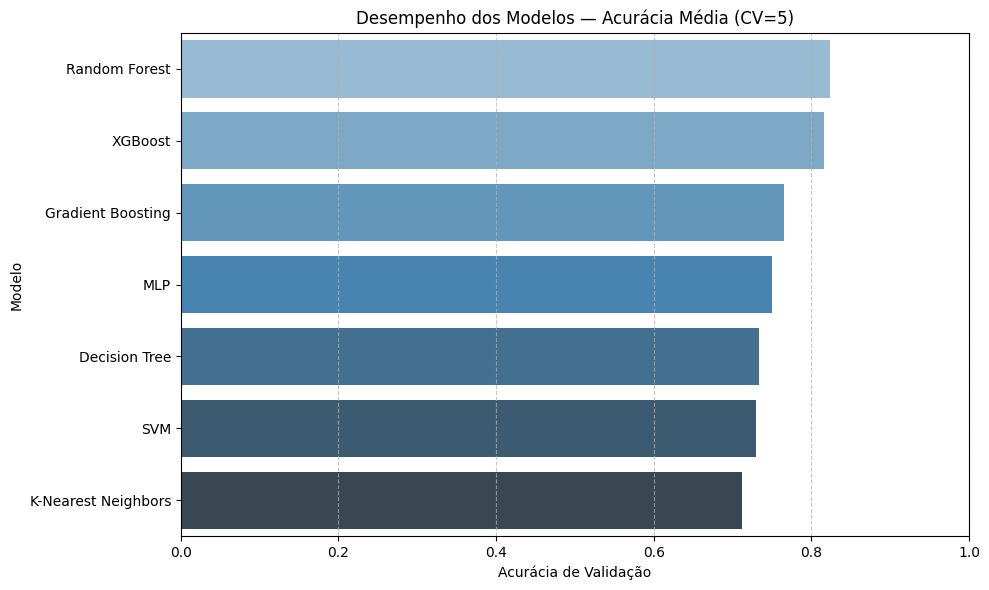

In [86]:
from sklearn.model_selection import cross_validate

resultados = []
fold_scores_dict = {}

# ESTIMADORES que não requerem normalização
ESTIMADORES_arvore = ["Decision Tree", "Random Forest", "Gradient Boosting", "XGBoost"]

for nome, modelo in ESTIMADORES.items():
    # Selecionar os dados corretos
    X_entrada = X if nome in ESTIMADORES_arvore else X_scaled

    # Avaliação com cross_validate para incluir scores de treino
    scores = cross_validate(
        estimator=modelo,
        X=X_entrada,
        y=y,
        cv=cv,
        scoring='accuracy',
        return_train_score=True
    )

    resultados.append({
        "Modelo": nome,
        "Acurácia Treino Média": scores['train_score'].mean(),
        "Acurácia Validação Média": scores['test_score'].mean(),
        "Desvio Padrão Validação": scores['test_score'].std()
    })

    # Scores por fold (validação)
    fold_scores_dict[nome] = scores['test_score']

# Resultados agregados
df_resultados = pd.DataFrame(resultados).sort_values(by="Acurácia Validação Média", ascending=False)
df_resultados.reset_index(drop=True, inplace=True)

# Resultados por fold
df_folds = pd.DataFrame(fold_scores_dict)
df_folds.index = [f"Fold {i+1}" for i in df_folds.index]

# Exibição dos resultados
print()
print(df_folds)
print()
print(df_resultados)
print()

# Gráfico
plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_resultados,
    x="Acurácia Validação Média",
    y="Modelo",
    hue="Modelo",
    palette="Blues_d",
    legend=False,
    errorbar=None
)

plt.title("Desempenho dos Modelos — Acurácia Média (CV=5)")
plt.xlabel("Acurácia de Validação")
plt.ylabel("Modelo")
plt.xlim(0, 1)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### 3.5 - Tuning de parametros


Apos, avancei para a afinação dos parametros dos estimadores.Durante a afinação de hiperparâmetros dos modelos testados, selecionei para cada estimador um conjunto de parâmetros com base em:

- Parametros que tivemos contacto em aulas teóricas da disciplina.
- A documentação oficial.
- Sugestões e ranges comuns utilizados na literatura e em competições.
- A necessidade de balancear entre diversidade de combinações e custo computacional.

A escolha dos valores em si dos hiperparâmetros levou em conta : 

- Sobre-ajustamento dos modelos.
- Valores default ( pois muitos dos estimadores desempenham bem, por si só ) 
- Valores extremos ( ou que simplifcam ou complexificam muito os modelos ), permitindo o ajuste.


#### 3.5.1 - Random Forest

In [37]:
# Grade de parâmetros para Random Forest
param_grid_rf = {
    'n_estimators': [100, 300, 500],
    'max_depth': [None, 20, 30, 40],  # None é o valor default
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy'],
    'random_state': [None, 42]  # None é o valor default
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_rf = GridSearchCV(
    estimator=ESTIMADORES['Random Forest'],
    param_grid=param_grid_rf,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execução do tuning
grid_rf.fit(X, y)

# DataFrame com todos os resultados
resultados_grid = pd.DataFrame(grid_rf.cv_results_)

# Top 5 combinações com treino + validação
scores = resultados_grid.sort_values(by="mean_test_score", ascending=False).head(5)

# Exibir os resultados
pd.set_option('display.max_colwidth', None) # opção para exibir os parametros por inteiro.
print("\nTop 5 combinações:")
print(scores[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

# Melhor combinação global
print("Melhores parâmetros encontrados:", grid_rf.best_params_)
print("Melhor acurácia média (CV=5):", grid_rf.best_score_)
print()

Fitting 5 folds for each of 144 candidates, totalling 720 fits

Top 5 combinações:
     rank_test_score  mean_train_score  mean_test_score  \
130                1               1.0         0.832392   
11                 2               1.0         0.831450   
59                 2               1.0         0.831450   
65                 2               1.0         0.831450   
5                  2               1.0         0.831450   

                                                                                                           params  
130  {'criterion': 'entropy', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': None}  
11      {'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 500, 'random_state': 42}  
59        {'criterion': 'gini', 'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}  
65        {'criterion': 'gini', 'max_depth': 40, 'max_features': 'log2', 'n_estimators': 500, 'ran

####  Considerações

- Os **melhores modelos apresentam overfitting**, com acurácia perfeita no treino (`mean_train_score = 1.0`).
- No entanto, a **acurácia média no teste é estável entre 83.1% e 83.2%**, o que indica **bom poder preditivo generalizado**.
- O valor `n_estimators = 500` aparece em todas as melhores combinações, o que **reforça sua solidez como escolha padrão** neste problema.

  **Apesar** do bom poder de generalização decidi limitar o **max_depth** para diminuir o overfitting e testar o resultado do modelo 

In [59]:
param_grid_rf_refinado = {
    'n_estimators': [500],  # mantido fixo
    'criterion': ['gini'],  # mantido fixo
    'max_depth': [10,12,17],  # testar limitação mais restrita para reduzir overfitting  # novos parâmetros para regularização
    'max_features': ['sqrt', 'log2'],
    'random_state': [42]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_rf_refinado = GridSearchCV(
    estimator=ESTIMADORES['Random Forest'],
    param_grid=param_grid_rf_refinado,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execução do tuning
grid_rf_refinado.fit(X, y)

# DataFrame com todos os resultados
resultados_grid_rf_refinado = pd.DataFrame(grid_rf_refinado.cv_results_)

# Top 5 combinações com treino + validação
scores = resultados_grid_rf_refinado.sort_values(by="mean_test_score", ascending=False).head(5)

# Exibir os resultados
pd.set_option('display.max_colwidth', None) # opção para exibir os parametros por inteiro.
print("\nTop 5 combinações:")
print(scores[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

# Melhor combinação global
print("Melhores parâmetros encontrados:", grid_rf_refinado.best_params_)
print("Melhor acurácia média (CV=5):", grid_rf_refinado.best_score_)
print()


Fitting 5 folds for each of 6 candidates, totalling 30 fits

Top 5 combinações:
   rank_test_score  mean_train_score  mean_test_score  \
4                1          0.999506         0.825800   
5                1          0.999506         0.825800   
2                3          0.964689         0.811676   
3                3          0.964689         0.811676   
0                5          0.907486         0.793315   

                                                                                                    params  
4  {'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}  
5  {'criterion': 'gini', 'max_depth': 17, 'max_features': 'log2', 'n_estimators': 500, 'random_state': 42}  
2  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}  
3  {'criterion': 'gini', 'max_depth': 12, 'max_features': 'log2', 'n_estimators': 500, 'random_state': 42}  
0  {'criterion': 'gini', 'max_de

##### A seguir, decidi continuar experiencias de regularização dos modelos. Experimentar modelos com mais estimadores e com max_depth menor numa tentativa de manter o desempenho do modelo.

In [63]:
param_grid_rf_refinado2 = {
    'n_estimators': [2000],  # mantido fixo
    'criterion': ['gini'],  # mantido fixo
    'max_depth': [8,10],  # testar limitação mais restrita para reduzir overfitting  # novos parâmetros para regularização
    'max_features': ['sqrt', 'log2'],
    'random_state': [42,100,150]
}


# GridSearch com validação cruzada e retorno dos scores de treino
grid_rf_refinado2 = GridSearchCV(
    estimator=ESTIMADORES['Random Forest'],
    param_grid=param_grid_rf_refinado2,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Execução do tuning
grid_rf_refinado2.fit(X, y)

# DataFrame com todos os resultados
resultados_grid_rf_refinado2 = pd.DataFrame(grid_rf_refinado2.cv_results_)

# Top 5 combinações com treino + validação
scores = resultados_grid_rf_refinado2.sort_values(by="mean_test_score", ascending=False).head(5)

# Exibir os resultados
pd.set_option('display.max_colwidth', None) # opção para exibir os parametros por inteiro.
print("\nTop 5 combinações:")
print(scores[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

# Melhor combinação global
print("Melhores parâmetros encontrados:", grid_rf_refinado2.best_params_)
print("Melhor acurácia média (CV=5):", grid_rf_refinado2.best_score_)
print()


Fitting 5 folds for each of 12 candidates, totalling 60 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
6                 1          0.908145         0.794256   
9                 1          0.908145         0.794256   
7                 3          0.908004         0.792750   
10                3          0.908004         0.792750   
8                 5          0.907886         0.792279   

                                                                                                       params  
6    {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 2000, 'random_state': 42}  
9    {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 2000, 'random_state': 42}  
7   {'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 2000, 'random_state': 100}  
10  {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 2000, 'random_state': 100}  
8   {'crit

#### 3.5.2 - SVM

Para o SVM optei por trabalhar uma alta amplitude de valores para os parametros C e Gamma de modo a compreender casos de sobre-ajustamento e sub-ajustamento, permitindo a escolha de um modelo intermediario.


In [38]:
# Grade de parâmetros para SVM (RBF)
param_grid_svc = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': ['scale', 0.01, 0.1, 1, 100]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_svc = GridSearchCV(
    estimator=ESTIMADORES['SVM'],
    param_grid=param_grid_svc,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Treino com dados normalizados
grid_svc.fit(X_scaled, y)

# DataFrame com todos os resultados
resultados_grid = pd.DataFrame(grid_svc.cv_results_)

# Top 5 combinações com treino + validação
scores = resultados_grid.sort_values(by="mean_test_score", ascending=False).head(5)

# Exibir os resultados
pd.set_option('display.max_colwidth', None)
print("\nTop 5 combinações:")
print(scores[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

# Melhor combinação global
print("Melhores parâmetros encontrados:", grid_svc.best_params_)
print("Melhor acurácia média (CV=5):", grid_svc.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
17                1          0.937359         0.783333   
15                2          0.922340         0.782109   
13                3          0.995857         0.769209   
12                4          0.866949         0.768738   
18                5          0.999906         0.766949   

                                           params  
17      {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}  
15  {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}  
13         {'C': 10, 'gamma': 1, 'kernel': 'rbf'}  
12       {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}  
18        {'C': 100, 'gamma': 1, 'kernel': 'rbf'}  

Melhores parâmetros encontrados: {'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}
Melhor acurácia média (CV=5): 0.7833333333333333




> ⚠️ **Nota**: Utilizo o scale pois é padrão atual desde o scikit-learn. essa opção Leva em conta a variância dos dados e Adapta-se   automaticamente ao escopo dos dados


#### SVC - POLINOMIAL 

Mais tarde, atentei-me que não estava a testar o SVC para um núcleo de polinomio com grau maior que 1. portanto criei uma nova instancia 
para SVC


In [49]:
# Grade de parâmetros para SVM com kernel polinomial
param_grid_svc_poly = {
    'kernel': ['poly'],
    'degree': [2, 3, 5],
    'C': [0.1, 1, 10],
    'coef0': [0, 1]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_svc_poly = GridSearchCV(
    estimator=SVC(),
    param_grid=param_grid_svc_poly,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Treino com dados normalizados
grid_svc_poly.fit(X_scaled, y)

# DataFrame com todos os resultados
resultados_grid_svc_poly = pd.DataFrame(grid_svc_poly.cv_results_)

# Top 5 combinações com treino + validação
top5_svc_poly = resultados_grid_svc_poly.sort_values(by="mean_test_score", ascending=False).head(5)

# Exibir os resultados
pd.set_option('display.max_colwidth', None)
print("\nTop 5 combinações:")
print(top5_svc_poly[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

# Melhor modelo
print("Melhores parâmetros encontrados:", grid_svc_poly.best_params_)
print("Melhor acurácia média (CV=5):", grid_svc_poly.best_score_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
17                1          0.940066         0.779002   
11                2          0.884251         0.774294   
16                3          0.853460         0.763559   
13                4          0.828837         0.750659   
5                 5          0.821069         0.746704   

                                                   params  
17   {'C': 10, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}  
11    {'C': 1, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}  
16   {'C': 10, 'coef0': 1, 'degree': 3, 'kernel': 'poly'}  
13   {'C': 10, 'coef0': 0, 'degree': 3, 'kernel': 'poly'}  
5   {'C': 0.1, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}  

Melhores parâmetros encontrados: {'C': 10, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}
Melhor acurácia média (CV=5): 0.7790018832391714


#### 3.5.3 - MLP

In [106]:
# Grade de parâmetros para MLP
param_grid_mlp = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50)],
    'activation': ['relu', 'tanh'],
    'alpha': [0.0001, 0.001],
    'learning_rate_init': [0.001, 0.01],
     'max_iter': [2500],
    'random_state': [42]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_mlp = GridSearchCV(
    estimator=ESTIMADORES['MLP'],
    param_grid=param_grid_mlp,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Treino com dados normalizados
grid_mlp.fit(X_scaled, y)

# Resultados
resultados_grid_mlp = pd.DataFrame(grid_mlp.cv_results_)
top5_mlp = resultados_grid_mlp.sort_values(by="mean_test_score", ascending=False).head(5)

pd.set_option('display.max_colwidth', None)
print("\nTop 5 combinações:")
print(top5_mlp[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_mlp.best_params_)
print("Melhor acurácia média (CV=5):", grid_mlp.best_score_)

Fitting 5 folds for each of 24 candidates, totalling 120 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
14                1          0.909746         0.783992   
20                2          0.912359         0.782768   
8                 3          0.867373         0.773823   
11                4          0.908451         0.773258   
5                 5          0.910946         0.773164   

                                                                                                                                       params  
14   {'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2500, 'random_state': 42}  
20    {'activation': 'tanh', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2500, 'random_state': 42}  
8     {'activation': 'relu', 'alpha': 0.001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2500, 'random_state':

#### 3.5.4  - XGBoost

In [96]:
# Grade de parâmetros para XGBoost
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1], 
    'random_state': [42]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_xgb = GridSearchCV(
    estimator=ESTIMADORES['XGBoost'],
    param_grid=param_grid_xgb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# XGBoost não precisa de normalização
grid_xgb.fit(X, y)

# Resultados
resultados_grid_xgb = pd.DataFrame(grid_xgb.cv_results_)
top5_xgb = resultados_grid_xgb.sort_values(by="mean_test_score", ascending=False).head(5)

pd.set_option('display.max_colwidth', None)
print("\nTop 5 combinações:")
print(top5_xgb[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_xgb.best_params_)
print("Melhor acurácia média (CV=5):", grid_xgb.best_score_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
46                1          1.000000         0.831262   
22                2          1.000000         0.829849   
47                3          1.000000         0.828437   
23                4          1.000000         0.826930   
44                5          0.999459         0.826742   

                                                                                                                         params  
46    {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}  
22  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}  
47      {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'subsample': 1}  
23    {'colsample_bytree': 0.8, 'learning_rate': 

####  3.5.5 - Knn

In [34]:
# Grade de parâmetros para KNN
param_grid_knn = {
    'n_neighbors': [2, 3, 5, 150],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_knn = GridSearchCV(
    estimator=ESTIMADORES['K-Nearest Neighbors'],
    param_grid=param_grid_knn,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# KNN precisa de dados normalizados
grid_knn.fit(X_scaled, y)

# Resultados
pd.set_option('display.max_colwidth', None)
resultados_grid_knn = pd.DataFrame(grid_knn.cv_results_)
top5_knn = resultados_grid_knn.sort_values(by="mean_test_score", ascending=False).head(5)

print("\nTop 5 combinações:")
print(top5_knn[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_knn.best_params_)
print("Melhor acurácia média (CV=5):", grid_knn.best_score_)


Fitting 5 folds for each of 16 candidates, totalling 80 fits

Top 5 combinações:
   rank_test_score  mean_train_score  mean_test_score  \
1                1               1.0         0.747458   
5                2               1.0         0.746516   
3                3               1.0         0.746516   
9                4               1.0         0.744068   
7                5               1.0         0.737853   

                                              params  
1  {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}  
5  {'n_neighbors': 3, 'p': 1, 'weights': 'distance'}  
3  {'n_neighbors': 2, 'p': 2, 'weights': 'distance'}  
9  {'n_neighbors': 5, 'p': 1, 'weights': 'distance'}  
7  {'n_neighbors': 3, 'p': 2, 'weights': 'distance'}  

Melhores parâmetros encontrados: {'n_neighbors': 2, 'p': 1, 'weights': 'distance'}
Melhor acurácia média (CV=5): 0.7474576271186442


#### Knn - Sobre-ajustado

Decidi buscar ajustar o K, buscando um balanço entre a performance entre teste e treino.



In [58]:
# Grade de parâmetros para KNN
param_grid_knn_refinado = {
    'n_neighbors': [30,25],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_knn_refinado = GridSearchCV(
    estimator=ESTIMADORES['K-Nearest Neighbors'],
    param_grid=param_grid_knn_refinado,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# KNN precisa de dados normalizados
grid_knn_refinado.fit(X_scaled, y)

# Resultados
pd.set_option('display.max_colwidth', None)
resultados_grid_knn_refinado = pd.DataFrame(grid_knn_refinado.cv_results_)
top5_knn = resultados_grid_knn_refinado.sort_values(by="mean_test_score", ascending=False).head(5)

print("\nTop 5 combinações:")
print(top5_knn[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_knn_refinado.best_params_)
print("Melhor acurácia média (CV=5):", grid_knn_refinado.best_score_)


Fitting 5 folds for each of 8 candidates, totalling 40 fits

Top 5 combinações:
   rank_test_score  mean_train_score  mean_test_score  \
5                1          1.000000         0.712806   
1                2          1.000000         0.708475   
7                3          1.000000         0.688701   
4                4          0.748540         0.685593   
0                5          0.738865         0.680791   

                                               params  
5  {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}  
1  {'n_neighbors': 30, 'p': 1, 'weights': 'distance'}  
7  {'n_neighbors': 25, 'p': 2, 'weights': 'distance'}  
4   {'n_neighbors': 25, 'p': 1, 'weights': 'uniform'}  
0   {'n_neighbors': 30, 'p': 1, 'weights': 'uniform'}  

Melhores parâmetros encontrados: {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
Melhor acurácia média (CV=5): 0.7128060263653484


#### 3.5.6 - Decision tree

In [95]:
# Grade de parâmetros para Decision Tree
param_grid_dt = {
    'max_depth': [12,15,20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'] # Função impureza
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_dt = GridSearchCV(
    estimator=ESTIMADORES['Decision Tree'],
    param_grid=param_grid_dt,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Decision Tree não precisa de normalização
grid_dt.fit(X, y)

# Resultados
resultados_grid_dt = pd.DataFrame(grid_dt.cv_results_)
top5_dt = resultados_grid_dt.sort_values(by="mean_test_score", ascending=False).head(5)

print("\nTop 5 combinações:")
print(top5_dt[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_dt.best_params_)
print("Melhor acurácia média (CV=5):", grid_dt.best_score_)

Fitting 5 folds for each of 54 candidates, totalling 270 fits

Top 5 combinações:
    rank_test_score  mean_train_score  mean_test_score  \
36                1          0.978908         0.745386   
45                2          0.998376         0.745104   
46                3          0.977166         0.742561   
37                4          0.962053         0.741996   
18                5          0.997105         0.737382   

                                                                                      params  
36  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}  
45  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}  
46  {'criterion': 'entropy', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5}  
37  {'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 5}  
18     {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2}  

#### 3.5.7 - Gradient Boosting

In [84]:
# Grade de parâmetros para Gradient Boosting
param_grid_gb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
}

# GridSearch com validação cruzada e retorno dos scores de treino
grid_gb = GridSearchCV(
    estimator=ESTIMADORES['Gradient Boosting'],
    param_grid=param_grid_gb,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)

# Gradient Boosting não precisa de normalização
grid_gb.fit(X, y)

# Resultados
resultados_grid_gb = pd.DataFrame(grid_gb.cv_results_)
top5_gb = resultados_grid_gb.sort_values(by="mean_test_score", ascending=False).head(5)

pd.set_option('display.max_colwidth', None)
print("\nTop 5 combinações:")
print(top5_gb[['rank_test_score', 'mean_train_score', 'mean_test_score', 'params']])
print()

print("Melhores parâmetros encontrados:", grid_gb.best_params_)
print("Melhor acurácia média (CV=5):", grid_gb.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits

Top 5 combinações:
   rank_test_score  mean_train_score  mean_test_score  \
5                1          1.000000         0.819209   
4                2          1.000000         0.814501   
3                3          0.998611         0.810640   
2                4          0.971375         0.800942   
1                5          0.909346         0.780979   

                                  params  
5  {'max_depth': 7, 'n_estimators': 200}  
4  {'max_depth': 7, 'n_estimators': 100}  
3  {'max_depth': 5, 'n_estimators': 200}  
2  {'max_depth': 5, 'n_estimators': 100}  
1  {'max_depth': 3, 'n_estimators': 200}  

Melhores parâmetros encontrados: {'max_depth': 7, 'n_estimators': 200}
Melhor acurácia média (CV=5): 0.8192090395480227


### 3.6 - Comparação Final dos Modelos após Tuning

Após a afinação dos hiperparâmetros de todos os modelos considerados neste trabalho, compilei os **melhores resultados obtidos com `GridSearchCV`** para cada estimador.

Observou-se um aumento substancial no desempenho de todos os modelos

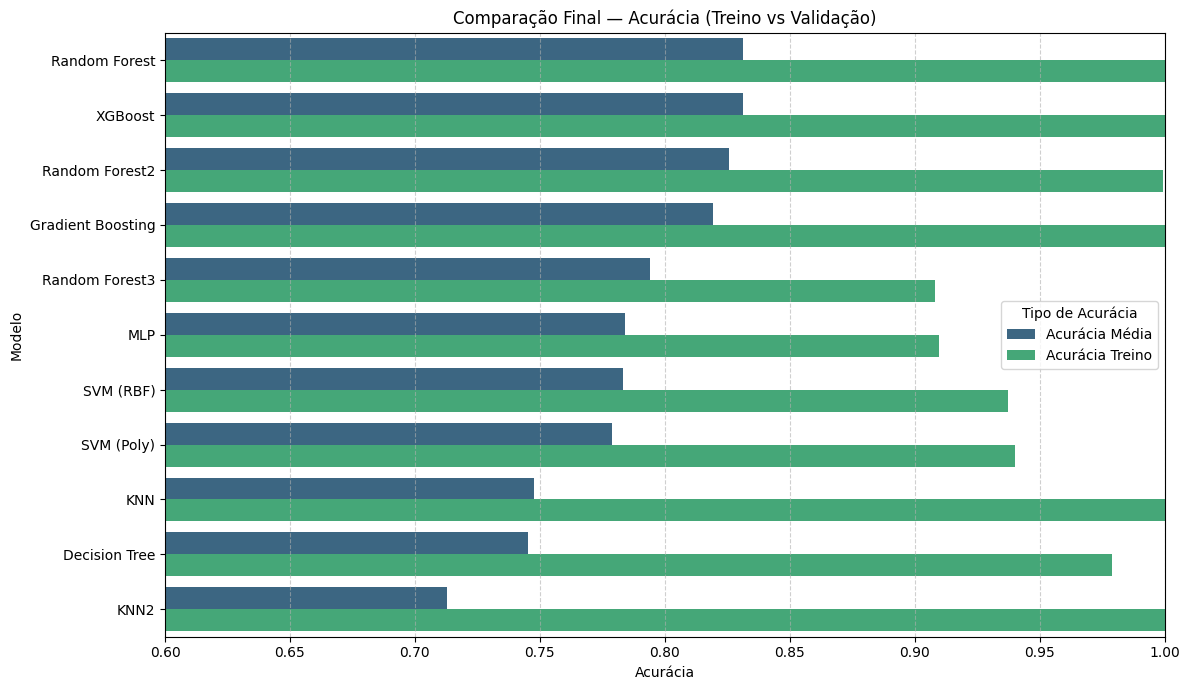

,Modelo,Acurácia Média,Acurácia Treino,Melhores Parâmetros
0,Random Forest,0.831450,1.000000,"{'criterion': 'gini', 'max_depth': 200, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}"
1,XGBoost,0.831262,1.000000,"{'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'random_state': 42, 'subsample': 0.8}"
2,Random Forest2,0.825800,0.999506,"{'criterion': 'gini', 'max_depth': 17, 'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42}"
3,Gradient Boosting,0.819209,1.000000,"{'max_depth': 7, 'n_estimators': 200}"
4,Random Forest3,0.794256,0.908145,"{'criterion': 'gini', 'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 2000, 'random_state': 42}"
5,MLP,0.783992,0.909746,"{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate_init': 0.001, 'max_iter': 2500, 'random_state': 42}"
6,SVM (RBF),0.783333,0.937359,"{'C': 100, 'gamma': 0.1, 'kernel': 'rbf'}"
7,SVM (Poly),0.779002,0.940066,"{'C': 10, 'coef0': 1, 'degree': 5, 'kernel': 'poly'}"
8,KNN,0.747458,1.000000,"{'n_neighbors': 2, 'p': 1, 'weights': 'distance'}"
9,Decision Tree,0.745386,0.978908,"{'criterion': 'entropy', 'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2}"


In [111]:
# Compilação dos melhores resultados de cada modelo
melhores_modelos = [
    {
        "Modelo": "Random Forest", 
        "Acurácia Média": grid_rf.best_score_,
        "Acurácia Treino": grid_rf.cv_results_["mean_train_score"][grid_rf.best_index_],
        "Melhores Parâmetros": grid_rf.best_params_
    },
    {
        "Modelo": "Random Forest2", 
        "Acurácia Média": grid_rf_refinado.best_score_,
        "Acurácia Treino": grid_rf_refinado.cv_results_["mean_train_score"][grid_rf_refinado.best_index_],
        "Melhores Parâmetros": grid_rf_refinado.best_params_
    },
    {
        "Modelo": "Random Forest3", 
        "Acurácia Média": grid_rf_refinado2.best_score_,
        "Acurácia Treino": grid_rf_refinado2.cv_results_["mean_train_score"][grid_rf_refinado2.best_index_],
        "Melhores Parâmetros": grid_rf_refinado2.best_params_
    },
    {
        "Modelo": "SVM (RBF)", 
        "Acurácia Média": grid_svc.best_score_,
        "Acurácia Treino": grid_svc.cv_results_["mean_train_score"][grid_svc.best_index_],
        "Melhores Parâmetros": grid_svc.best_params_
    },
    {
        "Modelo": "SVM (Poly)", 
        "Acurácia Média": grid_svc_poly.best_score_,
        "Acurácia Treino": grid_svc_poly.cv_results_["mean_train_score"][grid_svc_poly.best_index_],
        "Melhores Parâmetros": grid_svc_poly.best_params_
    },
    {
        "Modelo": "MLP", 
        "Acurácia Média": grid_mlp.best_score_,
        "Acurácia Treino": grid_mlp.cv_results_["mean_train_score"][grid_mlp.best_index_],
        "Melhores Parâmetros": grid_mlp.best_params_
    },
    {
        "Modelo": "XGBoost", 
        "Acurácia Média": grid_xgb.best_score_,
        "Acurácia Treino": grid_xgb.cv_results_["mean_train_score"][grid_xgb.best_index_],
        "Melhores Parâmetros": grid_xgb.best_params_
    },
    {
        "Modelo": "KNN2", 
        "Acurácia Média": grid_knn_refinado.best_score_,
        "Acurácia Treino": grid_knn_refinado.cv_results_["mean_train_score"][grid_knn_refinado.best_index_],
        "Melhores Parâmetros": grid_knn_refinado.best_params_
    },
    {
        "Modelo": "KNN", 
        "Acurácia Média": grid_knn.best_score_,
        "Acurácia Treino": grid_knn.cv_results_["mean_train_score"][grid_knn.best_index_],
        "Melhores Parâmetros": grid_knn.best_params_
    },
    {
        "Modelo": "Decision Tree", 
        "Acurácia Média": grid_dt.best_score_,
        "Acurácia Treino": grid_dt.cv_results_["mean_train_score"][grid_dt.best_index_],
        "Melhores Parâmetros": grid_dt.best_params_
    },
    {
        "Modelo": "Gradient Boosting", 
        "Acurácia Média": grid_gb.best_score_,
        "Acurácia Treino": grid_gb.cv_results_["mean_train_score"][grid_gb.best_index_],
        "Melhores Parâmetros": grid_gb.best_params_
    }
]

# DataFrame com todos os modelos e desempenho
df_melhores = pd.DataFrame(melhores_modelos).sort_values(by="Acurácia Média", ascending=False)
df_melhores.reset_index(drop=True, inplace=True)

# Gráfico comparando Acurácia de Validação e Treino
df_melt = df_melhores.melt(id_vars="Modelo", value_vars=["Acurácia Média", "Acurácia Treino"], 
                           var_name="Tipo de Acurácia", value_name="Valor")

plt.figure(figsize=(12, 7))
sns.barplot(data=df_melt, x="Valor", y="Modelo", hue="Tipo de Acurácia", palette="viridis")
plt.title("Comparação Final — Acurácia (Treino vs Validação)")
plt.xlabel("Acurácia")
plt.ylabel("Modelo")
plt.xlim(0.6, 1)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Tabela com parâmetros
pd.set_option('display.max_colwidth', None)
df_melhores[['Modelo', 'Acurácia Média', 'Acurácia Treino', 'Melhores Parâmetros']]

Podemos considerar o Tunning de parametro bem sucedido, pois, melhorou o desempenho de todos os modelos.

### 3.7 - Combinação de Modelos

Após a afinação dos hiperparâmetros com `GridSearchCV`, decidi selecionar **alguns dos modelos com melhor desempenho**  dos melhores estimadores — ex:`Random Forest`, `XGBoost` e `Gradient Boosting` — e combiná-los.
 
Para garantir reprodutibilidade dos resultados, incluí explicitamente o parâmetro `random_state=42` nos três modelos base.  
Este parâmetro, embora presente nos modelos desde o início, **ainda não estava a ser controlado diretamente durante os tunings anteriores**, o que poderia introduzir pequenas variações entre execuções.

A seguir, testei duas abordagens clássicas de ensemble:

#### VotingClassifier (votação suave) 

- É um tipo de **modelo de agregação paralela simples** — onde os modelos não dependem uns dos outros.

####  StackingClassifier (modelo meta-aprendizagem)

- Estratégia do tipo stacking.



In [123]:
# Definir os modelos base
rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=40,
    min_samples_leaf=1,
    n_estimators=300,
    random_state=42
)

xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

gb_model = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=200,
    random_state=42
)

In [124]:
# Ensemble por votação
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    voting='soft'
)


scores_voting = cross_val_score(voting_ensemble, X, y, cv=cv, scoring='accuracy')
print("Voting Ensemble - Acurácia média (CV=5):", scores_voting.mean())

Voting Ensemble - Acurácia média (CV=5): 0.8296610169491526


In [125]:
# Ensemble por stacking com Logistic Regression como meta-modelo
stacking_ensemble = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv
)

scores_stacking = cross_val_score(stacking_ensemble, X, y, cv=cv, scoring='accuracy')
print("Stacking Ensemble - Acurácia média (CV=5):", scores_stacking.mean())

Stacking Ensemble - Acurácia média (CV=5): 0.8338983050847457


## 4 - Submissão dos Modelos

Após realizar diversas experiências com **afinação de hiperparâmetros** e **combinação de modelos**, concluí que já dispunha de uma quantidade significativa de modelos que justificava avançar para a fase de submissão no Kaggle.

### Pré-Processamento - conjunto de teste

In [89]:
df_test = pd.read_csv('./classificacao-florestas/test.csv')

ids = df_test['id']
X_test = df_test.drop(columns=['id'])

# Normalizar teste 
X_test_scaled = scaler.transform(X_test)

In [98]:
# Carregar estrutura da submissão
sample_submission = pd.read_csv('./classificacao-florestas/sample_submission.csv')

### Submissão 1 

Decide começar por submeter estimadores de Random Forest. Optei por submeter 2, o melhor modelo ( mesmo estando sobre-ajustado ) e um modelo de menor desempenho, que apresenta menos sobre-ajustamento, visando um balanço entre complexidade do modelo e capacidade de generalização.

In [90]:
# Modelo 1 - Random Forest (dados originais)
rf1 = RandomForestClassifier(
    criterion='entropy',
    max_depth=40,
    max_features='sqrt',
    n_estimators=500,
    random_state=None
)
rf1.fit(X, y)
y_pred_1 = rf1.predict(X_test)

# Modelo 2 - Random Forest (dados originais)
rf2 = RandomForestClassifier(
    criterion='gini',
    max_depth=10,
    max_features='sqrt',
    n_estimators=500,
    random_state=42
)
rf2.fit(X, y)
y_pred_2 = rf2.predict(X_test)

In [91]:
# Submissão 1
submissao_rf1 = sample_submission.copy()
submissao_rf1['Cover_Type'] = y_pred_1
submissao_rf1.to_csv('submissao_rf1.csv', index=False)

# Submissão 2
submissao_rf2 = sample_submission.copy()
submissao_rf2['Cover_Type'] = y_pred_2
submissao_rf2.to_csv('submissao_rf2.csv', index=False)

| Ficheiro submetido          | Modelo / Hiperparâmetros principais                                | Score Privado | Score Público |
|----------------------------|---------------------------------------------------------------------|---------------|----------------|
| `prediction_RandomForest.csv`   | `criterion='entropy'`, `max_depth=40`, `n_estimators=500`             | **0.83311**   | **0.84364**    |
| `prediction_RandomForest2.csv`  | `criterion='gini'`, `max_depth=10`, `n_estimators=500`, `random_state=42` | **0.83440**   | **0.84126**    |


### Submissão 2 

Para segunda submissão escolhi os dois algoritmos de SVM, um com o núcleo Rbf e outro com o núcleo polinomial, de melhor desempenho. Para ambos os casos, obtivemos um bom balanço entre complexidade do modelo e generalização, mesmo que estes modelos tenham desempenho abaixo dos modelos da submissão 1.


In [99]:
if y_pred_rbf.min() == 0:
    y_pred_rbf += 1
if y_pred_poly.min() == 0:
    y_pred_poly += 1
    

# Submissão RBF
submissao_svm_rbf = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_rbf
})
submissao_svm_rbf.to_csv('submissao_svm_rbf.csv', index=False)

# Submissão POLY
submissao_svm_poly = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_poly
})
submissao_svm_poly.to_csv('submissao_svm_poly.csv', index=False)

| Ficheiro submetido         | Núcleo     | Hiperparâmetros principais                  | Score Público | Score Privado |
|---------------------------|------------|---------------------------------------------|---------------|----------------|
| `submissao_svm_rbf.csv`   | `rbf`      | `C=100`, `gamma=0.1`                         | **0.82290**   | **0.80744**    |
| `submissao_svm_poly.csv`  | `polynomial` | `C=10`, `degree=5`, `coef0=1`               | **0.81441**   | **0.79910**    |


### Submissão 3 

Para submissão terceira submissão selecionei o modelo do estimador MLP com o o melhor desempenho. 


In [109]:
# Treinar o modelo com os hiperparâmetros fornecidos
mlp = MLPClassifier(
    activation='tanh',
    alpha=0.0001,
    hidden_layer_sizes=(100,),
    learning_rate_init=0.001,
    max_iter=2500,
    random_state=42
)

mlp.fit(X_scaled, y)
y_pred_mlp = mlp.predict(X_test_scaled)

# Corrigir classes de 0–6 para 1–7, se necessário
if y_pred_mlp.min() == 0:
    y_pred_mlp += 1


# Submissão MLP
submissao_mlp = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_mlp
})

submissao_mlp.to_csv('submissao_mlp.csv', index=False)

| Ficheiro submetido     | Hiperparâmetros principais                                  | Score Público | Score Privado |
|------------------------|-------------------------------------------------------------|---------------|----------------|
| `submissao_mlp.csv`    | `activation='tanh'`, `hidden_layer_sizes=(100,)`, `max_iter=2500` | **0.79503**   | **0.81065**    |

### Submissão 4

A quarta submissão reservei para o estimador XGBoost. Optei por submeter o modelo que apresentava a melhor combinação de parametros.


In [ ]:
# Treinar o modelo com os hiperparâmetros ideais
xgb = XGBClassifier(
    colsample_bytree=1,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200,
    random_state=42,
    subsample=0.8
)


xgb.fit(X_scaled, y)
y_pred_xgb = xgb.predict(X_test_scaled)

# Corrigir classes de 0–6 para 1–7, se necessário
if y_pred_xgb.min() == 0:
    y_pred_xgb += 1

# Carregar estrutura base da submissão
sample_submission = pd.read_csv('./classificacao-florestas/sample_submission.csv')

# Submissão XGBoost
submissao_xgb = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_xgb
})

submissao_xgb.to_csv('submissao_xgb.csv', index=False)

| Ficheiro submetido     | Hiperparâmetros principais                                                       | Score Público | Score Privado |
|------------------------|----------------------------------------------------------------------------------|---------------|----------------|
| `submissao_xgb.csv`    | `max_depth=10`, `n_estimators=200`, `learning_rate=0.1`, `subsample=0.8`, `colsample_bytree=1`, `random_state=42` | **0.84980**   | **0.86267**    |

### Submissão 5 

A Quinta submissão foi feita com o melhor modelo do estimador de Knn e com o modelo que apresentou um bom balanço entre generalização e desempenho.

In [108]:
# Modelo 1: KNN 
knn1 = KNeighborsClassifier(n_neighbors=5, p=1, weights='distance')
knn1.fit(X_scaled, y)
y_pred_knn1 = knn1.predict(X_test_scaled)

# Modelo 2: KNN 
knn2 = KNeighborsClassifier(n_neighbors=25, p=1, weights='uniform')
knn2.fit(X_scaled, y)
y_pred_knn2 = knn2.predict(X_test_scaled)

# Garantir que as classes estão entre 1 e 7 (não de 0 a 6)
if y_pred_knn1.min() == 0:
    y_pred_knn1 += 1
if y_pred_knn2.min() == 0:
    y_pred_knn2 += 1

# Submissão KNN 1
submissao_knn1 = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_knn1
})
submissao_knn1.to_csv('submissao_knn_5_distance.csv', index=False)

# Submissão KNN 2
submissao_knn2 = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_knn2
})
submissao_knn2.to_csv('submissao_knn_25_uniform.csv', index=False)

| Ficheiro submetido                | Hiperparâmetros principais                          | Score Público | Score Privado |
|----------------------------------|------------------------------------------------------|---------------|----------------|
| `submissao_knn_5_distance.csv`   | `n_neighbors=5`, `p=1`, `weights='distance'`         | **0.78562**   | **0.78687**    |
| `submissao_knn_25_uniform.csv`   | `n_neighbors=25`, `p=1`, `weights='uniform'`         | **0.73042**   | **0.73725**    |


### Submissão  6 

Na sexta submissão escolhi o melhor modelo Decision Tree. Esse modelo conseguiu equilibrar a capacidade de ajuste e generalização.


In [110]:
# Treinar o modelo
dt = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=15,
    min_samples_leaf=1,
    min_samples_split=2
)

dt.fit(X, y)
y_pred_dt = dt.predict(X_test)

# Corrigir classes (0–6 → 1–7), se necessário
if y_pred_dt.min() == 0:
    y_pred_dt += 1



# Submissão Decision Tree
submissao_dt = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_dt
})

submissao_dt.to_csv('submissao_dt.csv', index=False)

| Ficheiro submetido     | Hiperparâmetros principais                                                      | Score Público | Score Privado |
|------------------------|----------------------------------------------------------------------------------|---------------|----------------|
| `submissao_dt.csv`     | `criterion='entropy'`, `max_depth=15`, `min_samples_split=2`, `min_samples_leaf=1` | **0.77600**   | **0.77663**    |

### Submissão 7 

Melhor modelo de Gradient Boosting Classifier.

In [112]:
# Instanciar e treinar o modelo
gb = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=200
)

gb.fit(X, y)

y_pred_gb = gb.predict(X_test)

# Corrigir classes de 0–6 para 1–7, se necessário
if y_pred_gb.min() == 0:
    y_pred_gb += 1

# Submissão Gradient Boosting
submissao_gb = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_gb
})

submissao_gb.to_csv('submissao_gb.csv', index=False)

| Ficheiro submetido     | Hiperparâmetros principais             | Score Público | Score Privado |
|------------------------|----------------------------------------|---------------|----------------|
| `submissao_gb.csv`     | `max_depth=7`, `n_estimators=200`      | **0.84942**   | **0.8491**    |

### Submissão 8

Submissão dos modelos de Ensable.

#### Voting Ensamble

In [122]:
# Definir os modelos base
rf_model = RandomForestClassifier(
    criterion='gini',
    max_depth=40,
    min_samples_leaf=1,
    n_estimators=300,
    random_state=42
)

xgb_model = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.1,
    max_depth=10,
    n_estimators=200,
    subsample=0.8,
    random_state=42
)

gb_model = GradientBoostingClassifier(
    max_depth=7,
    n_estimators=200,
    random_state=42
)

# Ensemble por votação (soft)
voting_ensemble = VotingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    voting='soft'
)

# Treinar e prever
voting_ensemble.fit(X, y)
y_pred_voting = voting_ensemble.predict(X_test)

# Corrigir classes se necessário
if y_pred_voting.min() == 0:
    y_pred_voting += 1




| Ficheiro submetido        | Modelos combinados                            | Tipo de Votação | Score Público | Score Privado |
|---------------------------|-----------------------------------------------|------------------|---------------|----------------|
| `submissao_voting.csv`    | RandomForest + XGBoost + GradientBoosting     | `soft`           | **0.86165**   | **0.84852**    |

#### Stacking Classifier

In [120]:
# Definir o ensemble empilhado (stacking)
stacking_ensemble = StackingClassifier(
    estimators=[
        ('rf', rf_model),
        ('xgb', xgb_model),
        ('gb', gb_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=cv
)

# Treinar e prever
stacking_ensemble.fit(X_scaled, y)
y_pred_stacking = stacking_ensemble.predict(X_test_scaled)

# Corrigir classes se necessário
if y_pred_stacking.min() == 0:
    y_pred_stacking += 1

# Criar submissão final
submissao_stacking = pd.DataFrame({
    'id': sample_submission['id'],
    'floresta': y_pred_stacking
})

submissao_stacking.to_csv('submissao_stacking.csv', index=False)

| Ficheiro submetido           | Estimadores base                        | Score Público | Score Privado  |
|------------------------------|-----------------------------------------|---------------|----------------|
| `submissao_stacking.csv`     | RandomForest, XGBoost, GradientBoosting |  **0.86301**   | **0.85109**   |

## 5. Caracterização dos Dois Melhores Modelos

Com base no **score público** do Kaggle, os dois melhores modelos desenvolvidos ao longo do trabalho foram:

- **StackingClassifier** (Score público: **0.86301**, Score privado: **0.85109** )
- **XGBoost** (Score público: **0.86267**, Score privado: **0.84980** )

### 5.1 StackingClassifier

O modelo com melhor desempenho público utilizou uma estratégia de **empilhamento (Stacking)**, combinando os alguns dos melhores modelos  obtidos pelas experiências de **tuning de parâmetros** na secção 3.5 dos estimadores **Random Forest**, **XGBoost** e **Gradient Boosting**. 

O modelo final foi uma **Regressão Logística** ( agregador ). A combinação foi validada com `cv=5`, a estratégia de **validação cruzada estratificada** definida e utilizada durante o trabalho. 

Estimadores :

- **Random Forest**:
  - `criterion='gini'`, `max_depth=40`, `min_samples_leaf=1`, `n_estimators=300`, `random_state=42`

- **XGBoost**:
   - `colsample_bytree=0.8`, `learning_rate=0.1`, `max_depth=10`, `n_estimators=200`, `subsample=0.8`, `random_state=42`

- **Gradient Boosting**:
  - `max_depth=7`, `n_estimators=200`, `random_state=42`

> **Nota**: Se o Leaderboard estivesse aberto, este modelo teria alcançado a **7.ª posição**.

### 5.2 XGBoost

O segundo melhor modelo foi um **XGBoost** otimizado com os seguintes hiperparâmetros:

- `max_depth = 10`
- `n_estimators = 200`
- `learning_rate = 0.1`
- `subsample = 0.8`
- `colsample_bytree = 0.8`

> **Nota**: Este modelo teria alcançado a **8.ª posição**.


## 6. Conclusão



O trabalho teve como estratégia basear-se inicialmente na seleção de um conjunto diversificado de estimadores padrão (com hiperparâmetros default), seguidos de:

- **Aplicação de validação cruzada** para uma avaliação consistente do desempenho;
- **Normalização dos dados** para adequar-se a estimadores sensíveis à escala;
- **Experiências de tuning de hiperparâmetros**, com o objetivo de maximizar a performance de cada modelo;
- **Empilhamento (Stacking)** dos melhores modelos encontrados.

Esta abordagem mostrou-se acertada: o melhor modelo produzido foi justamente um **StackingClassifier** composto pelos estimadores que apresentaram os melhores desempenhos individuais após tuning (Random Forest, XGBoost e Gradient Boosting). Este modelo obteve o **7.º lugar no leaderboard público** da competição, superando todas as submissões isoladas.

> **Nota** : Embora o modelo de **XGBoost** tenha alcançado o segundo lugar no ranking, o modelo baseado em **Voting Ensemble** ficou logo em seguida, na terceira posição, com um score muito semelhante. Este resultado reforça a validade da estratégia adotada, demonstrando que a combinação de modelos bem ajustados pode alcançar desempenhos competitivos mesmo quando comparada a modelos isolados de alto desempenho.

Ao longo do trabalho, foi realizado um número significativo de experiências:

- **166 modelos Random Forest**
- **54 modelos Decision Tree**
- **48 modelos XGBoost**
- **38 modelos SVM**
- **24 modelos MLP**
- **24 modelos KNN**
- **6 modelos Gradient Boosting**
- **+ Modelos combinados via Stacking e Voting**
- **+ Outras experiências exploratórias não incluídas no relatório final**

Este volume experimental reflete o bom desempenho final dos melhores modelos e a robustes do trabalho de pesquisa.

> **Nota** : Devido ao custo computacional elevado de alguns estimadores — como o **XGBoost**, **Random Forest** e **MLP** —, o processo de tuning teve que ser restringido em certos momentos. Isto implicou deixar de fora alguns hiperparâmetros ou limitar o número de combinações testadas, particularmente em modelos com múltiplos níveis de profundidade ou número elevado de estimadores.

#### Submissões e Resultados

No total, foram **submetidos 12 modelos diferentes ao Kaggle**, sendo os dois melhores colocados:

- **7.º lugar público** — `StackingClassifier`
- **8.º lugar público** — `XGBoost`

Estes resultados validam a estratégia adotada e evidenciam o valor da combinação de modelos (ensembles) para problemas de classificação complexos com múltiplas variáveis.

---

Durante o processo experimental, observou-se que vários modelos apresentaram sinais claros de **sobreajustamento** ao conjunto de treino. Como melhoria futura, seria recomendável aplicar estratégias mais robustas de regularização e/ou validação mais rigorosa no tuning de hiperparâmetros, de forma a melhorar o equilíbrio entre **ajuste e generalização**.

Assim, ao longo das várias etapas, foi desenvolvida uma abordagem progressiva e iterativa que se revelou eficaz, culminando na construção de modelos com forte capacidade de generalização.
